Тебе дали задание проанализировать  
1) что влияет на успешность рекурента  
2) какие есть проблемы у текущей модели  
3) какую метрику лучше всего использовать для анализа модели и выбора лучшей  

А также построить собственную модель прогнозирования.  


Исходные данные:  
* current_dt - в какой момент времени была собрана информация  
* user_id - уникальный индефикатор пользователя  
* scheduled_dt - дата на которую запланировано автопродление  
* root_order_id - уникальный индефикатор подписки  
* gender - пол пользователя  
* age - возраст пользователя  
* os_family - операционная система пользователя  
* lt_user - lifetime пользователя  
* hours_after_reg_buy - через сколько часов после регистрации пользователь оформил подписку  
* country_code - страна пользователя  
* phone - марка телефона пользователя  
* cpa - СPA по которому был привлечен пользователь  
* retry_number - номер попытки автопродлить подписку  
* period - на какой период оформлена подписка  
* gross - сколько стоит продление подписки  
* currency_id - валюта в какой оформлена подписка  
* discount - размер скидки на продление  
* psp - платежный шлюз  
* last_response_code - при неудачных попытках автопродлить подписку платежный сервис отдает причину неудачи (response_code)
* last_response_code - говорит какой был ответ при прошлой попытке продлить подписку пользователю  
* bank - банк в котором оформлена карта пользователя  
* was_3ds - проходило ли оформление подписки через 3D Secure  
* card_type - тип карты  
* card_country_code - страна оформления карты  
* success_orders - количество успешных оплат пользователя  
* not_success_orders - количество не успешных оплат пользователя  
* insufficients - количество не успешных оплат пользователя по причине недостаточного количества средств на карте  
* root_gross - на какую сумму пользователь уже оформил данную подписку  
* not_root_gross - какую сумму пользователь потратил без учета данной подписки   
* old_model_probability - вероятность успешного продления данной подписки, которое отдает старая модель  
* is_success - результат - произошло ли продление подписки   


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data_science_dataset_test_task (1).csv')

In [4]:
df.head().T

,0,1,2,3,4
Unnamed: 0,37,45,46,47,51
current_dt,2019-05-12 05:40:15.355095,2019-06-07 08:10:15.982701,2019-06-07 08:10:15.982701,2019-06-08 03:10:13.314904,2019-06-07 08:10:15.982701
user_id,13801584,16144816,16467614,16467614,16482460
scheduled_dt,2019-06-09 00:00:00.000000,2019-06-09 00:00:00.000000,2019-06-09 00:00:00.000000,2019-06-09 00:00:00.000000,2019-06-09 00:00:00.000000
root_order_id,96601292,116843195,116847635,116847635,116953235
gender,f,f,f,f,m
age,43,25,45,45,45
os_family,11,11,11,11,11
lt_user,2,4,1,2,1
hours_after_reg_buy,0,76,0,0,0


"Unnamed: 0" seems to be an id of a log table 

In [5]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# dfto_csv("dfto_db.csv", index=False)

### Exploratory data analysis

#### Explore target variable 

In [6]:
target_col = 'is_success'

In [7]:
df[target_col].value_counts()

0    410204
1    105976
Name: is_success, dtype: int64

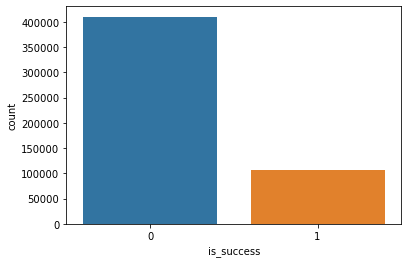

In [8]:
sns.countplot(x=target_col, data=df)

Imbalanced binary classification dataset  


Need to balance the dataset before training classifier.  
1. subsampling (taking a smaller yet equal selection of samples from each class)  
1. upsampling (taking repeat samples from some classes to increase its numbers)  
1. resampling (using an algorithm like SMOTE to augment the dataset with artificial data)

#### Explore dataset 

In [9]:
features_to_drop = []

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,516180.0,1.394521e+07,2.486363e+06,9.446267e+06,1.180498e+07,1.401039e+07,1.616694e+07,1.809049e+07
root_order_id,516180.0,9.849996e+07,1.836157e+07,6.596732e+07,8.271771e+07,9.829443e+07,1.146021e+08,1.309793e+08
age,516180.0,3.614343e+01,1.066496e+01,1.800000e+01,2.800000e+01,3.600000e+01,4.300000e+01,8.600000e+01
os_family,516180.0,9.564890e+00,2.974220e+00,1.000000e+00,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
lt_user,516180.0,2.269883e+00,1.105913e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
hours_after_reg_buy,516180.0,6.061773e+00,1.487820e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.100000e+02
country_code,516180.0,2.288364e+01,5.702782e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.700000e+02
phone,516165.0,2.672034e+03,1.674057e+03,1.000000e+00,1.136000e+03,2.374000e+03,4.368000e+03,5.700000e+03
cpa,516180.0,8.912365e-01,1.818934e+00,0.000000e+00,0.000000e+00,5.000000e-01,1.082113e+00,8.337500e+01
retry_number,516180.0,3.351370e-01,5.822847e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516180 entries, 0 to 516179
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   current_dt             516180 non-null  object 
 1   user_id                516180 non-null  int64  
 2   scheduled_dt           516180 non-null  object 
 3   root_order_id          516180 non-null  int64  
 4   gender                 516180 non-null  object 
 5   age                    516180 non-null  int64  
 6   os_family              516180 non-null  int64  
 7   lt_user                516180 non-null  int64  
 8   hours_after_reg_buy    516180 non-null  int64  
 9   country_code           516180 non-null  int64  
 10  phone                  516165 non-null  float64
 11  cpa                    516180 non-null  float64
 12  retry_number           516180 non-null  int64  
 13  period                 516180 non-null  int64  
 14  gross                  516180 non-nu

All id columns must be removed for prediction  
Same for old_model_prediction

In [12]:
features_to_drop.append(['user_id', 'root_order_id', 'old_model_probability'])

Explore the missing values

In [13]:
(df.isnull().mean() * 100).sort_values(ascending=False)

bank                     6.513813
card_type                4.816537
phone                    0.002906
current_dt               0.000000
discount                 0.000000
old_model_probability    0.000000
not_root_gross           0.000000
root_gross               0.000000
insufficients            0.000000
not_success_orders       0.000000
success_orders           0.000000
card_country_code        0.000000
was_3ds                  0.000000
last_response_code       0.000000
psp                      0.000000
currency_id              0.000000
user_id                  0.000000
gross                    0.000000
period                   0.000000
retry_number             0.000000
cpa                      0.000000
country_code             0.000000
hours_after_reg_buy      0.000000
lt_user                  0.000000
os_family                0.000000
age                      0.000000
gender                   0.000000
root_order_id            0.000000
scheduled_dt             0.000000
is_success    

Only 3 features contain NaNs:  
* "bank" feature contains 7%
* "card_type" contains 5%
* "phone" contains < 0.1% 

For future predictions, they might be filled with mean or median values, depending on data distributions.  
Since they are less than 10%, I will drop them.

In [14]:
df.dropna(inplace=True)

Inconsistency with dtypes for date columns. Сonvert date columns to datetime format 

In [15]:
datetime_cols = ['current_dt', 'scheduled_dt']

In [16]:
df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)

Get insight from the time period stored in log files

In [17]:
str(df['current_dt'].dt.date.min()) + ' to ' + str(df['current_dt'].dt.date.max())

'2019-04-04 to 2019-06-26'

Feature engeneering  
Extract number of days left until the end of the subscription

In [18]:
df['scheduled_dt_current_dt_days_diff'] = (df['scheduled_dt'] - df['current_dt']).dt.days

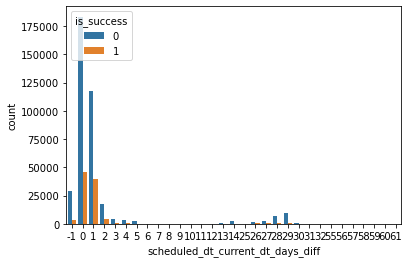

In [19]:
sns.countplot(x='scheduled_dt_current_dt_days_diff', hue=target_col, data=df)

In [20]:
features_to_drop.append(datetime_cols)

Take a look at ordered dataset by "user_id" and "current_dt"

In [21]:
(df.sort_values(by=['user_id', 'current_dt'])).head(50)

,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,country_code,...,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success,scheduled_dt_current_dt_days_diff
227448,2019-04-04 09:29:44.187065,9446267,2019-04-06,65967320,m,26,11,4,0,154,...,5.0,154,2,1,1,0.26,0.26,0.109008,0,1
401554,2019-04-04 09:29:44.187065,9446429,2019-04-05,65967736,f,30,11,4,0,154,...,2.0,154,1,2,2,0.26,0.00,0.088488,0,0
401868,2019-04-04 09:29:44.187065,9446508,2019-04-05,65983504,m,38,11,4,0,62,...,2.0,62,1,3,3,2.97,0.00,0.158307,0,0
363522,2019-04-04 09:29:44.187065,9446570,2019-05-01,66000058,m,22,3,4,0,203,...,2.0,203,3,0,0,10.74,2.40,0.422028,0,26
505208,2019-04-04 09:29:44.187065,9446570,2019-04-06,66002102,m,22,3,4,0,203,...,2.0,203,3,0,0,1.20,11.94,0.304009,1,1
28509,2019-04-04 09:29:44.187065,9446580,2019-04-05,65974584,m,46,11,4,0,1,...,2.0,1,1,2,2,0.48,0.00,0.153299,0,0
353715,2019-04-04 09:29:44.187065,9446604,2019-04-05,65984843,m,45,3,4,0,1,...,2.0,1,1,3,2,0.48,0.00,0.161285,0,0
127526,2019-04-04 09:29:44.187065,9446665,2019-04-05,65991273,m,28,11,4,0,1,...,5.0,1,1,2,2,0.39,0.00,0.136426,0,0
125484,2019-04-04 09:29:44.187065,9446686,2019-04-06,68777837,m,20,11,4,94,154,...,2.0,154,2,4,3,0.26,0.26,0.073366,0,1
336911,2019-04-04 09:29:44.187065,9446728,2019-04-05,66879645,f,41,3,4,32,1,...,2.0,1,1,3,3,0.48,0.00,0.100591,0,0


Data contains multiple rows for the same user

Get the most frequent duplicated users in data to discover the difference between rows 

In [22]:
user_id_mode_vals = df['user_id'].mode()

In [23]:
df['user_id'].mode()

0    10259984
1    11680411
dtype: int64

In [24]:
df[df['user_id'].isin(user_id_mode_vals)].sort_values(by=['user_id', 'current_dt']).T

,163977,163976,164546,133036,164547,199521,234704,247160,379506,247161,379507,217000,380827,217001
current_dt,2019-04-08 12:37:15.359365,2019-04-09 12:37:18.809619,2019-04-09 12:37:18.809619,2019-04-10 15:25:25.430434,2019-04-10 15:25:25.430434,2019-04-11 15:25:33.022667,2019-04-11 15:25:33.022667,2019-04-21 09:52:25.682053,2019-04-21 09:52:25.682053,2019-04-22 09:52:17.675891,2019-04-22 09:52:17.675891,2019-04-23 09:52:20.571080,2019-04-23 09:52:20.571080,2019-04-24 09:52:20.196516
user_id,10259984,10259984,10259984,10259984,10259984,10259984,10259984,11680411,11680411,11680411,11680411,11680411,11680411,11680411
scheduled_dt,2019-04-10 00:00:00,2019-04-10 00:00:00,2019-05-08 00:00:00,2019-04-11 00:00:00,2019-05-08 00:00:00,2019-06-08 00:00:00,2019-04-12 00:00:00,2019-04-23 00:00:00,2019-05-21 00:00:00,2019-04-23 00:00:00,2019-05-21 00:00:00,2019-06-21 00:00:00,2019-05-23 00:00:00,2019-06-21 00:00:00
root_order_id,71894870,71894870,71896023,71894870,71896023,74495066,71894870,81605035,81607923,81605035,81607923,83368640,81605035,83368640
gender,m,m,m,m,m,m,m,f,f,f,f,f,f,f
age,44,44,44,44,44,44,44,37,37,37,37,37,37,37
os_family,11,11,11,11,11,11,11,11,11,11,11,11,11,11
lt_user,1,2,2,3,3,4,4,1,1,2,2,3,3,4
hours_after_reg_buy,3,3,3,3,3,84,3,0,0,0,0,56,0,56
country_code,92,92,92,92,92,92,92,1,1,1,1,1,1,1


Examine concrete example

In [25]:
user_id_mode_vals[0]

10259984

In [26]:
df[df['user_id'].isin([user_id_mode_vals[1]])].sort_values(by=['current_dt']).T.drop_duplicates()

,247160,379506,247161,379507,217000,380827,217001
current_dt,2019-04-21 09:52:25.682053,2019-04-21 09:52:25.682053,2019-04-22 09:52:17.675891,2019-04-22 09:52:17.675891,2019-04-23 09:52:20.571080,2019-04-23 09:52:20.571080,2019-04-24 09:52:20.196516
user_id,11680411,11680411,11680411,11680411,11680411,11680411,11680411
scheduled_dt,2019-04-23 00:00:00,2019-05-21 00:00:00,2019-04-23 00:00:00,2019-05-21 00:00:00,2019-06-21 00:00:00,2019-05-23 00:00:00,2019-06-21 00:00:00
root_order_id,81605035,81607923,81605035,81607923,83368640,81605035,83368640
gender,f,f,f,f,f,f,f
age,37,37,37,37,37,37,37
os_family,11,11,11,11,11,11,11
lt_user,1,1,2,2,3,3,4
hours_after_reg_buy,0,0,0,0,56,0,56
country_code,1,1,1,1,1,1,1


Significant changes:
* "lt_user"
* "hours_after_reg_buy"
* "retry_number"
* "gross"
* "last_response_code"
* "success_orders"
* "not_success_orders"
* "root_gross"
* "not_root_gross"

#### Explore categorical features

In [27]:
cat_features = []

Count unique values in a column  
Select features with < 5000 unique elements  

In [28]:
# For pretty print
feature_name_max_len = max(len(col) for col in df.columns)

for col in df.columns:
    if df[col].nunique() < 5000:
        cat_features.append(col)
        
    print('{:>{width}}: {:>8}'.format(col, df[col].nunique(), width=feature_name_max_len))

                       current_dt:       83
                          user_id:   172428
                     scheduled_dt:       83
                    root_order_id:   187925
                           gender:        2
                              age:       64
                        os_family:       11
                          lt_user:        5
              hours_after_reg_buy:      110
                     country_code:       96
                            phone:     4239
                              cpa:    19196
                     retry_number:        4
                           period:        5
                            gross:     3972
                      currency_id:       15
                         discount:        3
                              psp:        8
               last_response_code:       37
                             bank:     1239
                          was_3ds:        2
                        card_type:        4
                card_country_cod

Drop non-categorical features that were occasionally selected

In [29]:
print(cat_features)

['current_dt', 'scheduled_dt', 'gender', 'age', 'os_family', 'lt_user', 'hours_after_reg_buy', 'country_code', 'phone', 'retry_number', 'period', 'gross', 'currency_id', 'discount', 'psp', 'last_response_code', 'bank', 'was_3ds', 'card_type', 'card_country_code', 'success_orders', 'not_success_orders', 'insufficients', 'root_gross', 'not_root_gross', 'is_success', 'scheduled_dt_current_dt_days_diff']


In [30]:
for col in ['current_dt', 'scheduled_dt', 'age', 'hours_after_reg_buy', 'gross', 'root_gross', 'not_root_gross', target_col]:
    cat_features.remove(col)

Visualize categorical columns depending on target_variable

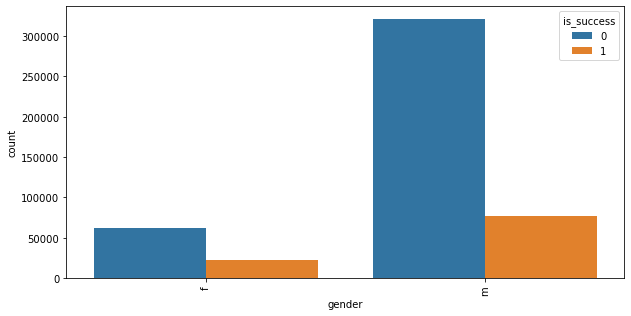

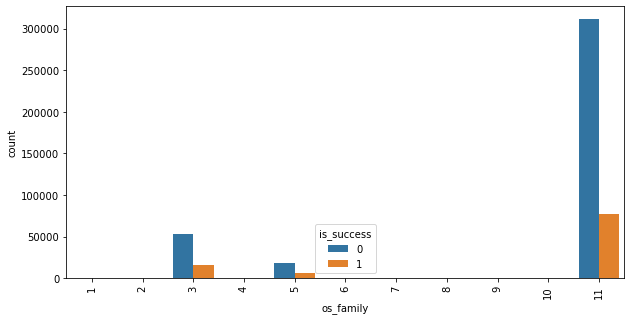

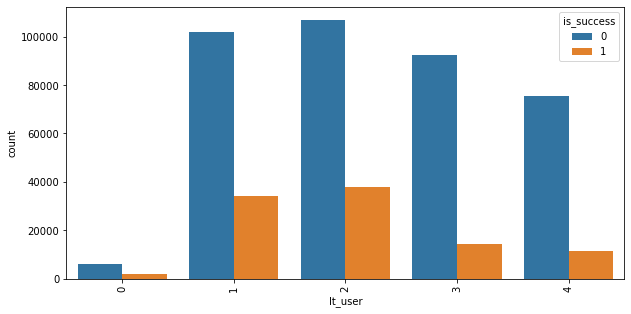

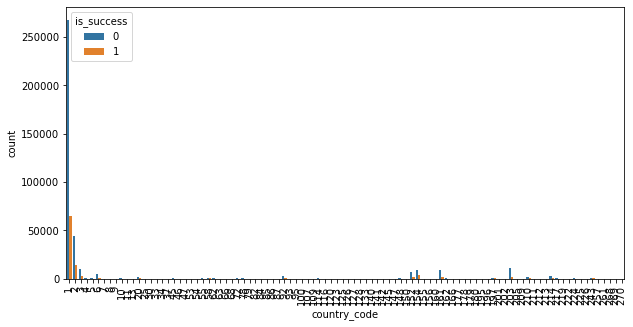

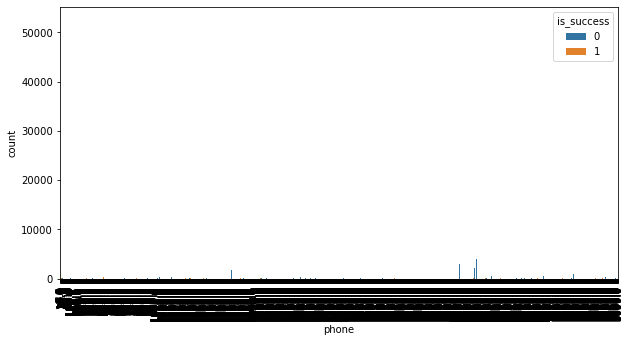

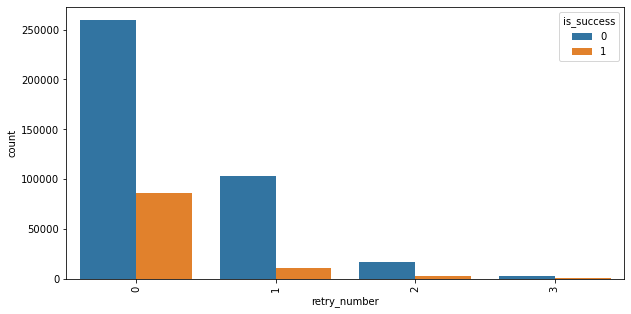

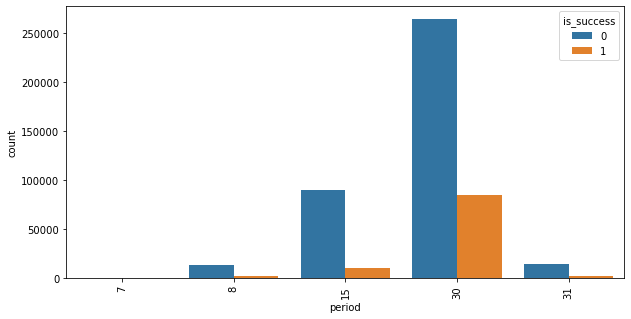

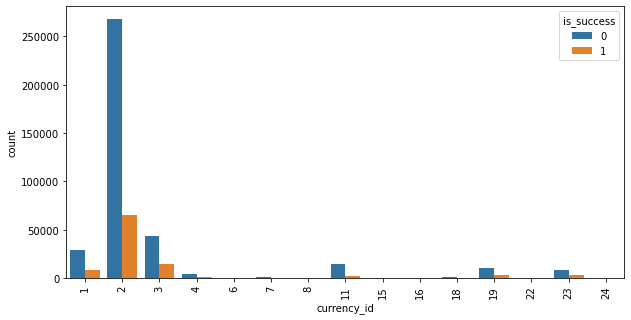

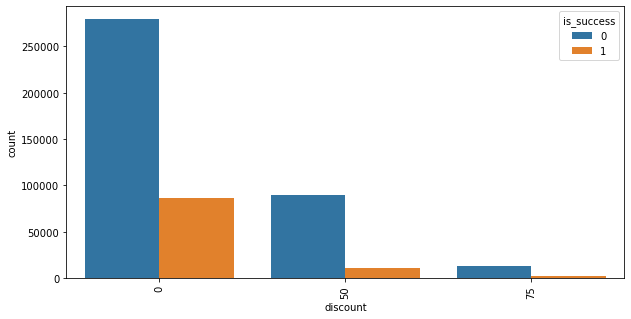

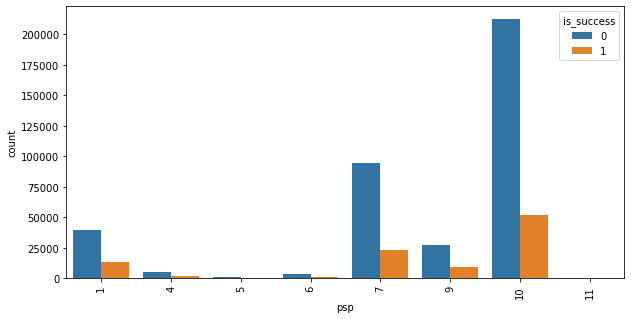

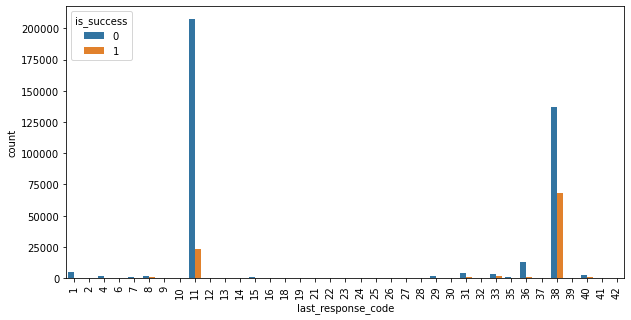

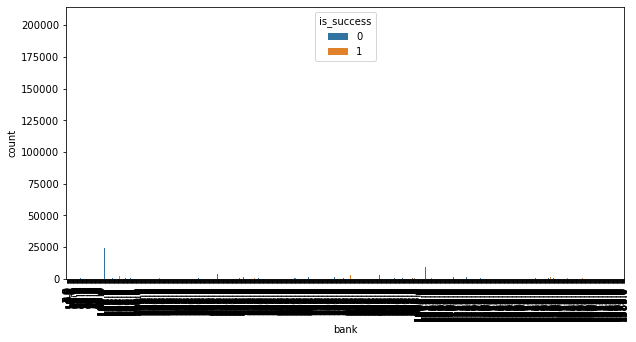

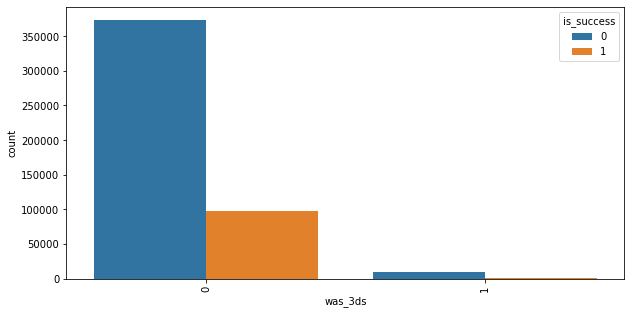

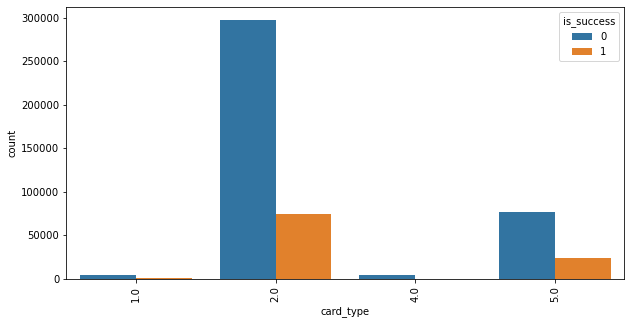

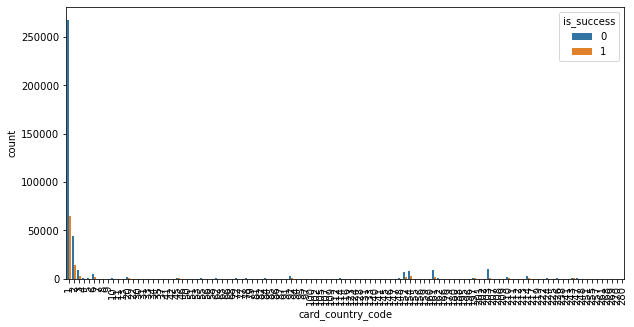

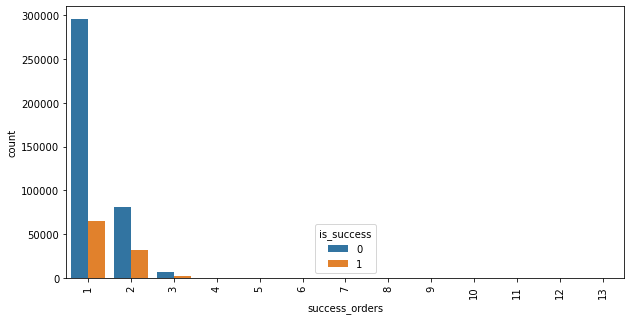

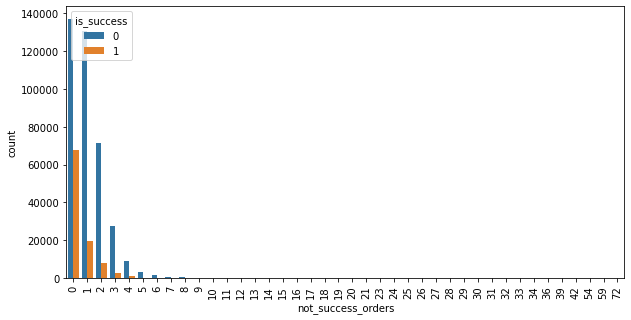

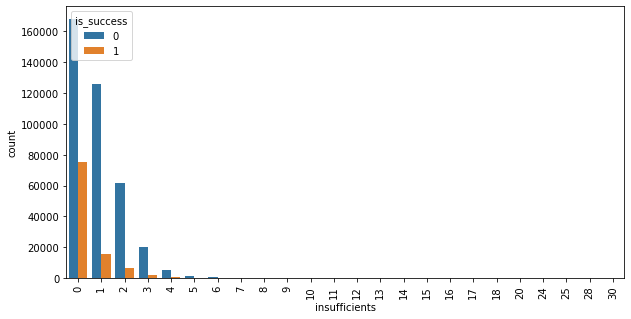

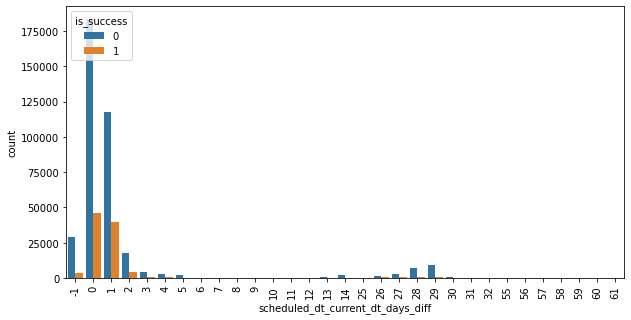

In [31]:
for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue=target_col, data=df)
    plt.xticks(rotation=90)

Some column categories contain very few values that can be removed to improve the complexity of the model.

In [32]:
cat_features_freq_table = df[cat_features].stack().value_counts().tolist()

Explore quartiles of the categories counts

In [33]:
q1_cat_freq_table, q3_cat_freq_table = np.percentile(cat_features_freq_table, [25, 75])
print('Q1 = {}\nQ3 = {}'.format(q1_cat_freq_table, q3_cat_freq_table))

Q1 = 4.0
Q3 = 42.0


In [34]:
# dfcopy = dfcopy()

Remove catogories less than threshold

In [35]:
cat_threshold = q3_cat_freq_table

for col in cat_features:
    value_counts = df[col].value_counts() # Specific column 
    to_remove = value_counts[value_counts <= cat_threshold].index
    df[col].replace(to_remove, np.nan, inplace=True)

Plot categorical features based on our target column

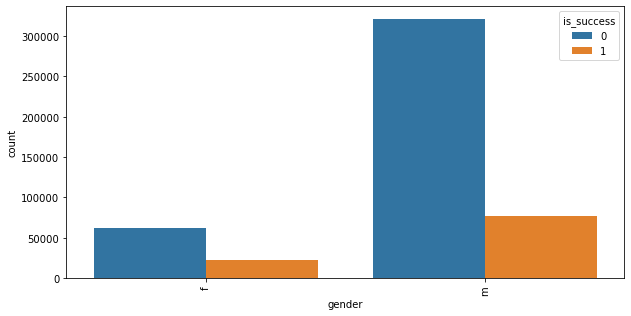

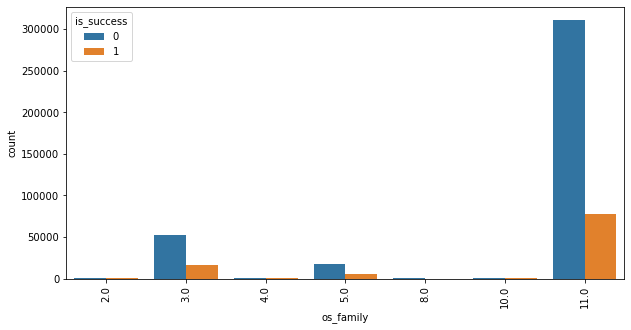

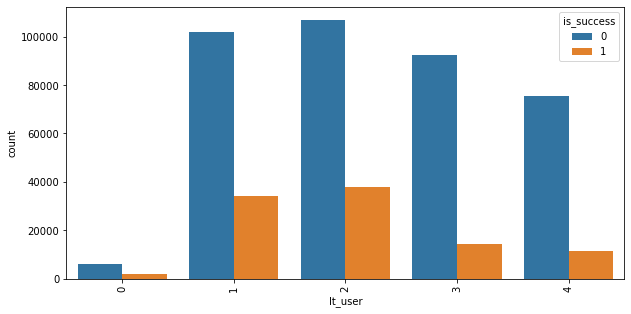

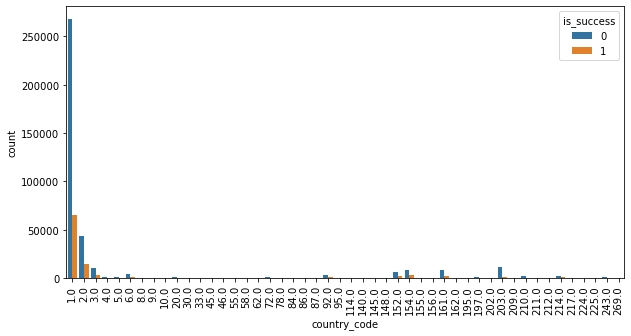

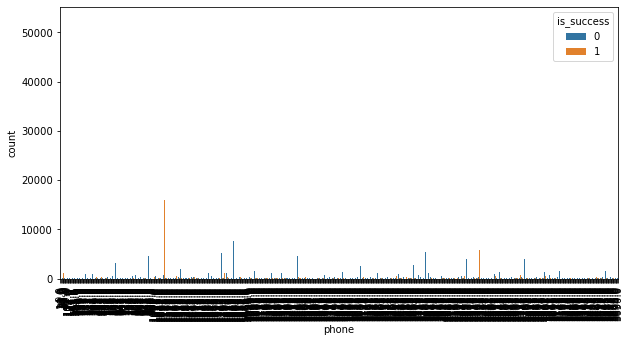

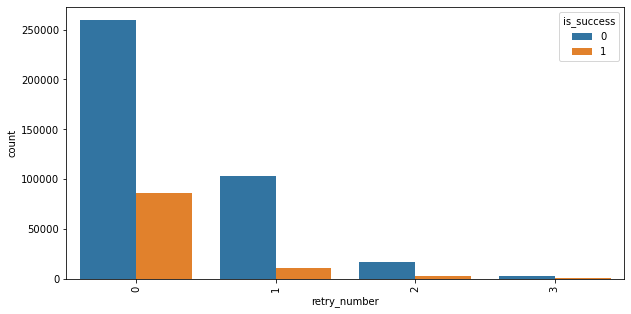

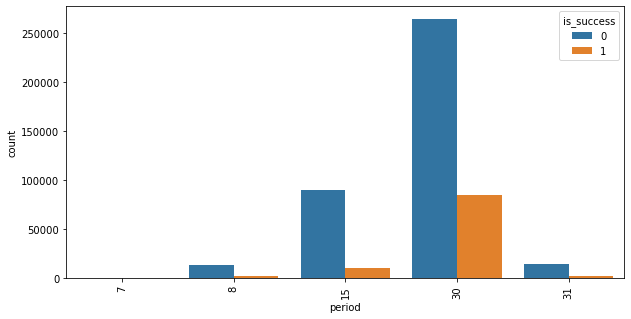

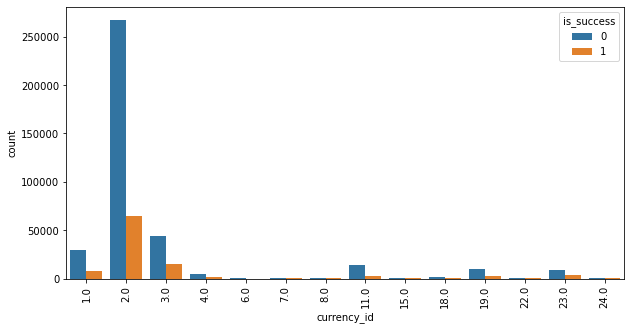

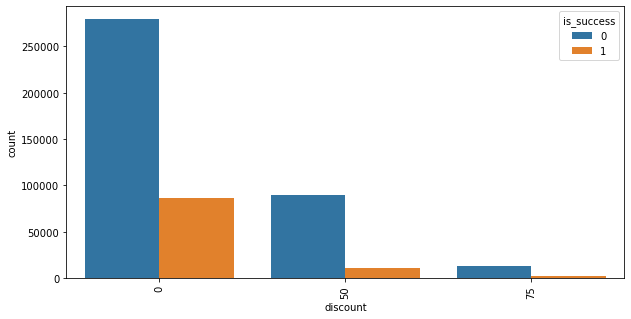

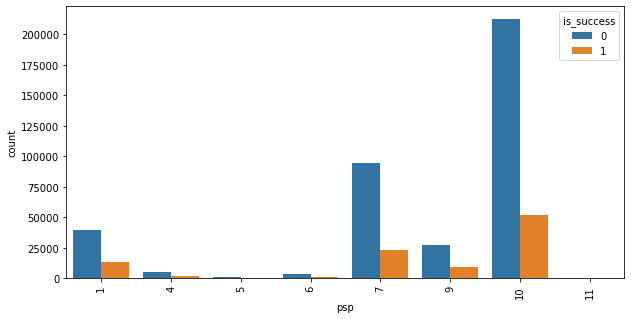

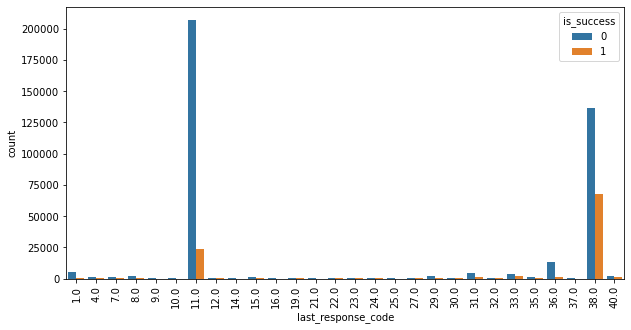

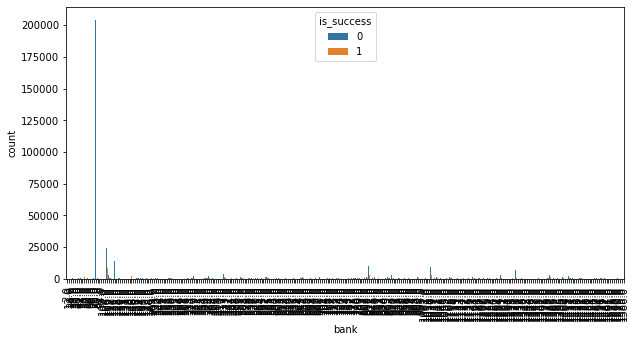

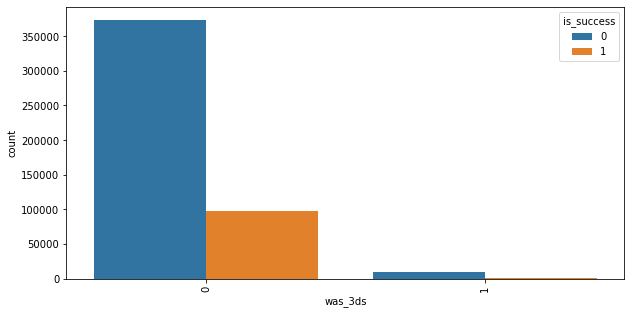

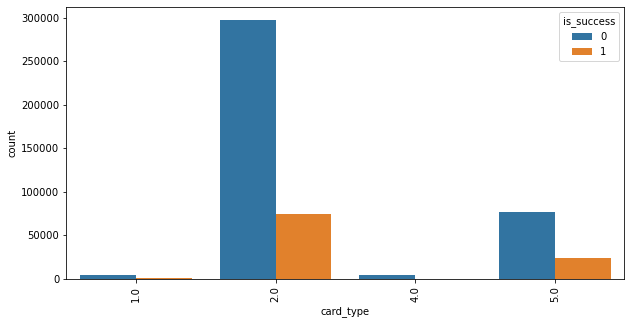

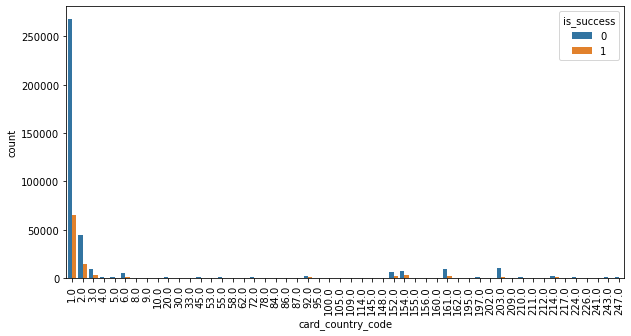

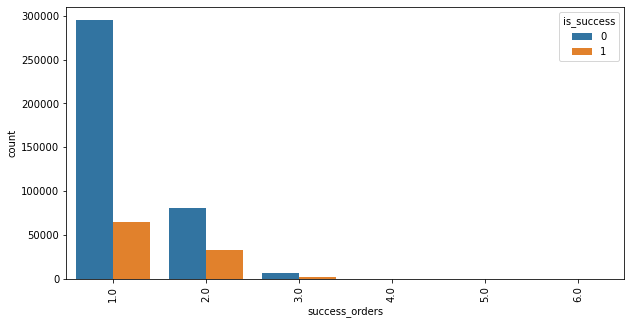

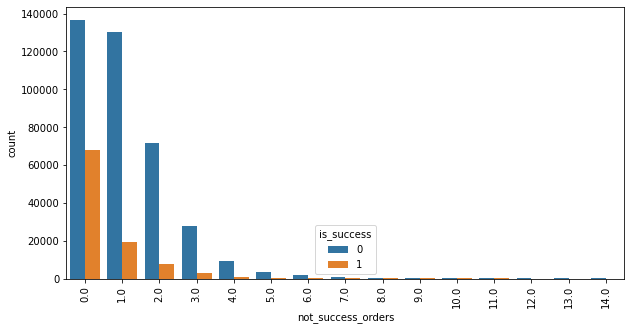

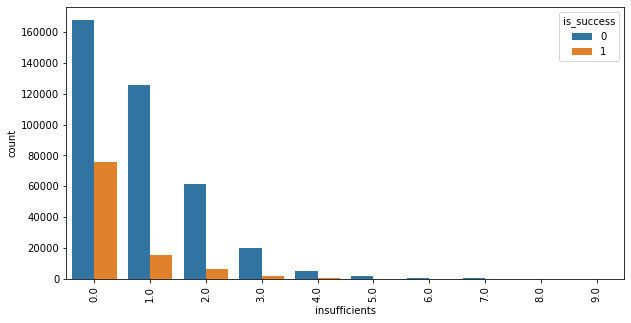

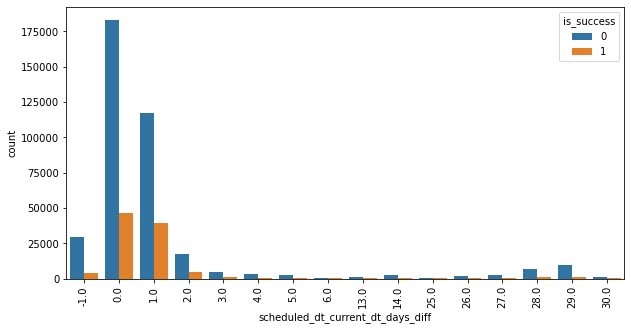

In [36]:
for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue=target_col, data=df)
    plt.xticks(rotation=90)

Encode gender column

In [37]:
df['gender_male'] = pd.get_dummies(df['gender'], drop_first=True)

In [38]:
cat_features.append('gender_male')

In [39]:
features_to_drop.append('gender')

#### Explore continuous variables 

In [40]:
cont_features = df.columns.difference(cat_features)

Visualize continuous columns

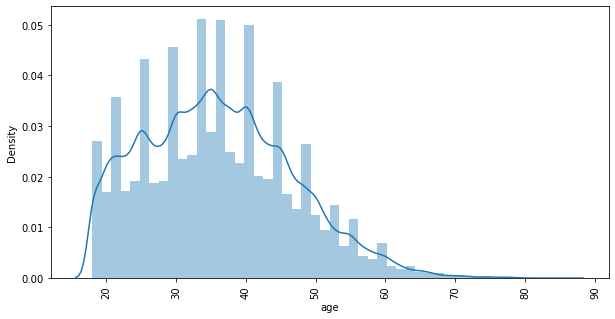

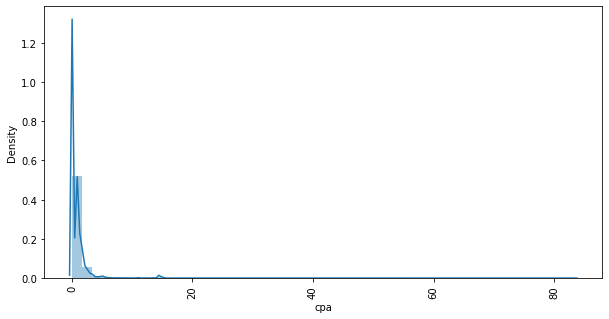

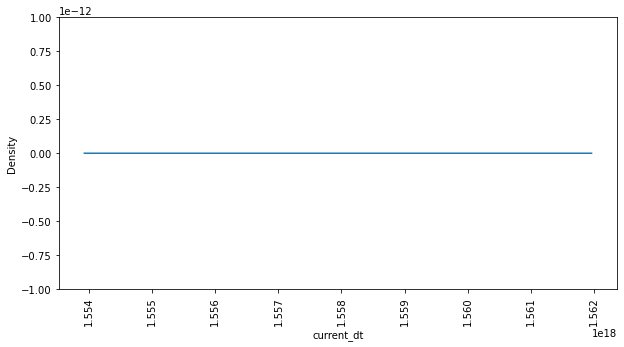

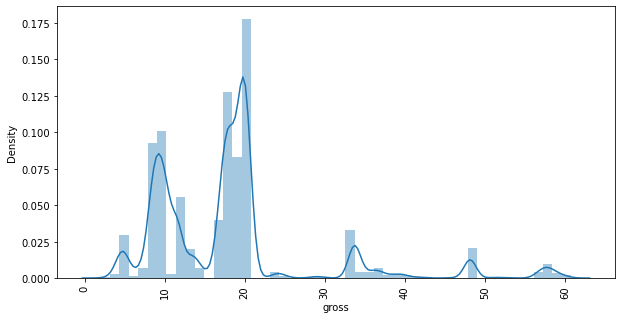

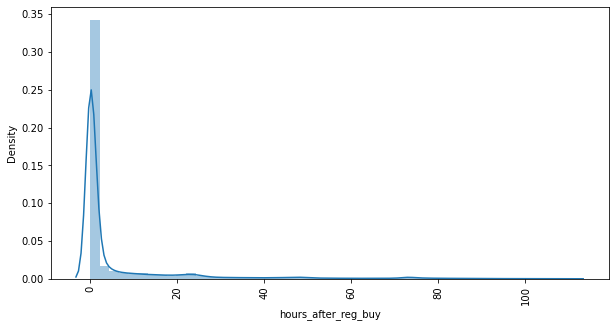

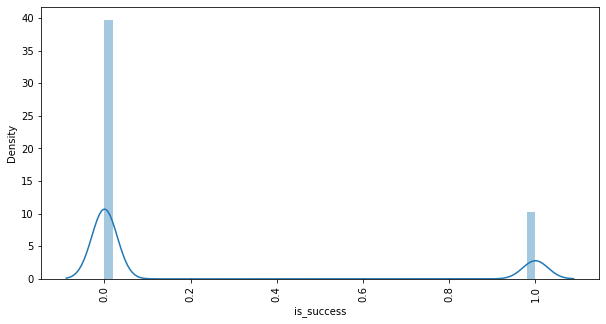

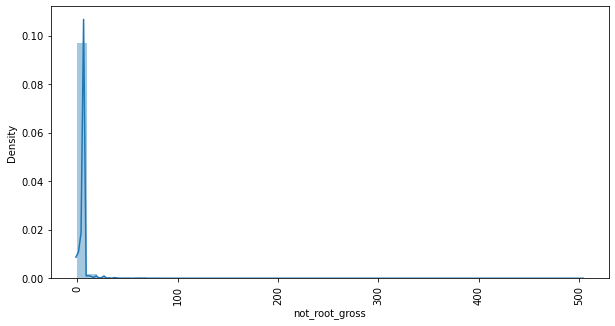

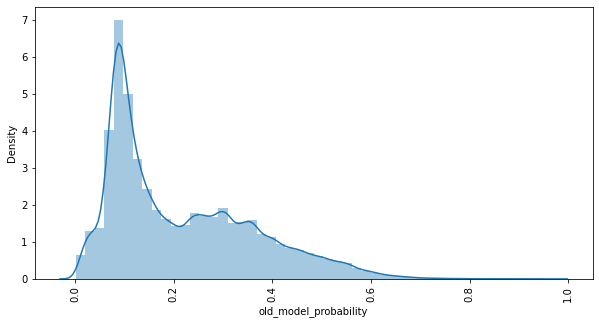

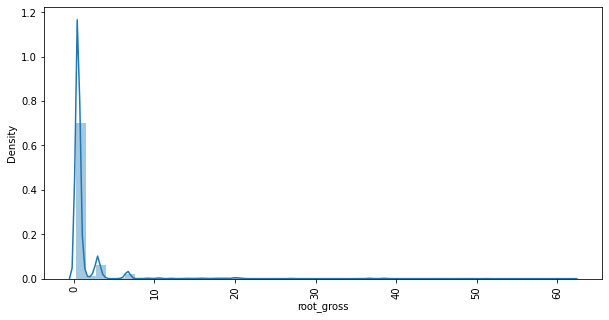

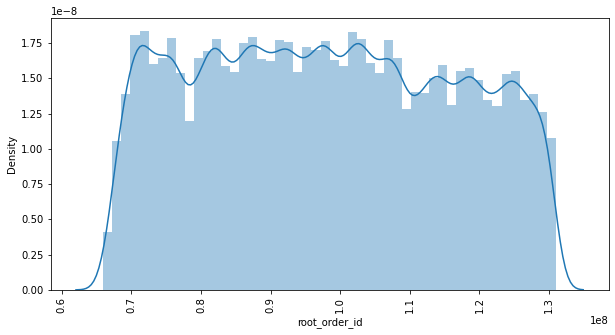

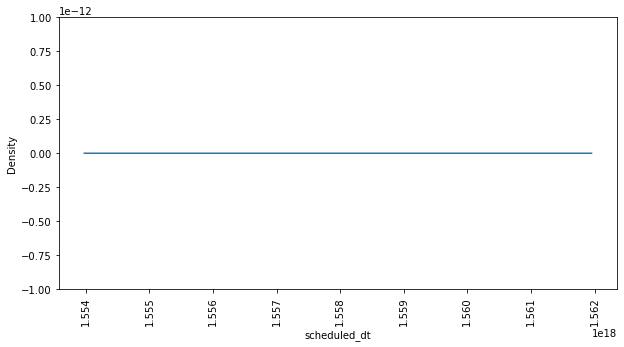

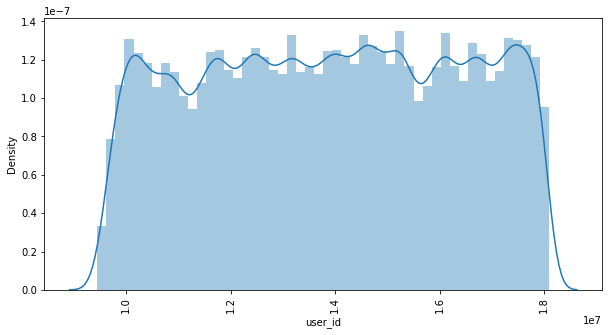

In [41]:
for col in cont_features:
    plt.figure(figsize=(10, 5))
    sns.distplot(df[col])
    plt.xticks(rotation=90)

Apply log-transformation to decrease skewness to columns:
* "cpa"
* "gross"
* "hours_after_reg_day"
* "not_root_gross"
* "root_gross"

In [42]:
log_transformed_features = ['cpa', 'gross', 'hours_after_reg_buy', 'not_root_gross', 'root_gross']

In [43]:
log_transformed_features_ending = '_log_transf'

for col in log_transformed_features:
    df[col+log_transformed_features_ending] = np.log(df[col]+1)

Categorize continuous variables into bins

Bins:  
* cpa_log -> 3  
* gross_log -> 9  
* hours_after_reg_buy_log -> 5  
* not_root_log -> 5  
* root_log -> 5  
* age -> 11  

In [44]:
cont_cols_to_cat = []
cont_cols_to_cat_bins = [3, 9, 5, 5, 5, 11]

In [45]:
for col in log_transformed_features:
    cont_cols_to_cat.append(col+log_transformed_features_ending)

cont_cols_to_cat.append('age')

In [46]:
features_to_drop.append(log_transformed_features)

Apply categorization

In [47]:
cont_cols_to_cat_ending = '_cat'

for col, bins in zip(cont_cols_to_cat, cont_cols_to_cat_bins):
    cat_vals, cat_bins = pd.qcut(df[col], q=bins, retbins=True, duplicates='drop')
    df[col+cont_cols_to_cat_ending] = pd.cut(df[col], bins=cat_bins, labels=False, include_lowest=True)

Visualize categorized columns

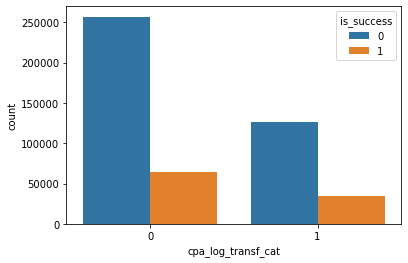

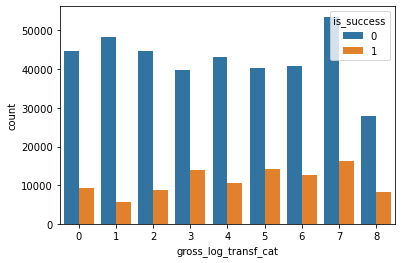

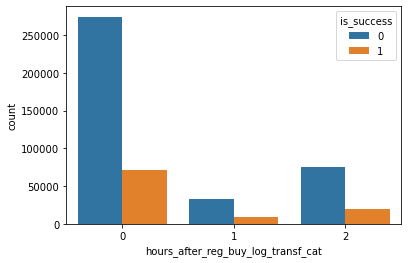

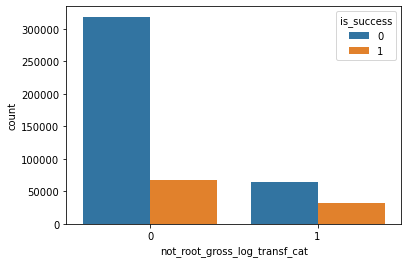

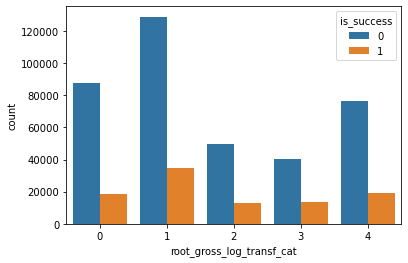

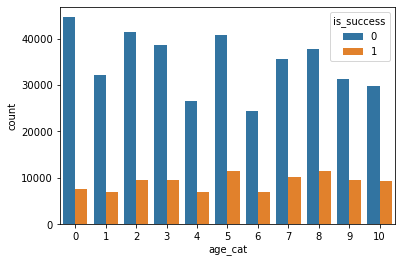

In [48]:
for col in cont_cols_to_cat:
    plt.figure()
    sns.countplot(x=col+cont_cols_to_cat_ending, hue=target_col, data=df)

In [49]:
features_to_drop.append('age')

### Old model evaluation

To evaluate predictions of the current model:  
1. Choose appropriate binary classification performance measure  
2. Find optimal threshold to convert model probabilities into exact predictions  
3. Convert values  
4. Evaluate the model  

For our task with imbalanced target variable the appropriate evaluation metric is Precision-Recall curve

In [50]:
from sklearn.metrics import precision_recall_curve

Find optimal threshold

In [51]:
precision, recall, thresholds = precision_recall_curve(df[target_col], df['old_model_probability'])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

In [52]:
# locate the index of the largest f score
ix = np.nanargmax(fscore)
optimal_threshold = thresholds[ix]

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.257015, F-Score=0.470


Visualize Precision-Cecall Curve with optimal threshold

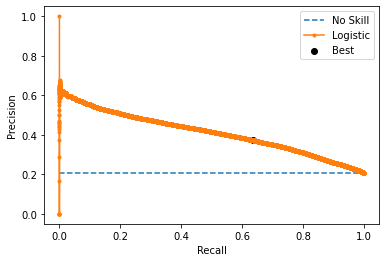

In [53]:
no_skill = df[target_col].sum() / df[target_col].shape[0]
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

Convert probabilities into predictions

In [54]:
y_pred_old_model = np.where(df['old_model_probability'] > optimal_threshold, 1, 0)

Build a confusion matrix to get the performance of the old model

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
tn, fp, fn, tp = confusion_matrix(df[target_col], y_pred_old_model).ravel()
print(confusion_matrix(df[target_col], y_pred_old_model))

[[276420 106446]
 [ 36241  63264]]


In [57]:
# TN | FP
# -------
# FN | TP

Classification metrics

In [58]:
from sklearn.metrics import classification_report

In [59]:
print(classification_report(df[target_col], y_pred_old_model))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79    382866
           1       0.37      0.64      0.47     99505

   micro avg       0.70      0.70      0.70    482371
   macro avg       0.63      0.68      0.63    482371
weighted avg       0.78      0.70      0.73    482371



#### Conclusion based on the old model
* The model predicts almost three times more subscription prolongations as there are actually are (only 37% actually are). For future improvements, it's better to train a classifier on more data with prolongations, since that is a minor class.     
* The model successfully classifies 63% of subscription prolongations.  
* The model successfully classifies 72% of NOT subscription prolongations.


### Pipeline for data preprocessing

Build pipeline for data preprocessing

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [61]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [62]:
class DropCols(TransformerMixin):
    def __init__(self, by_index=True, idx=0, cols=None):
        self.by_index = by_index
        self.idx = idx
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if self.by_index is True:
            self.cols = X.columns[self.idx]            
        
        if type(self.cols) is list:
            for cols in self.cols:
                X.drop(cols, axis=1, inplace=True)
        else:
            X.drop(self.cols, axis=1, inplace=True)

        return X

In [63]:
class DatetimeConverter(TransformerMixin):
    def __init__(self, cols, dtype=pd.to_datetime, new_feature=True):
        self.dtype = dtype
        self.cols = cols
        self.new_feature = new_feature
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X[self.cols] = X[self.cols].apply(self.dtype)
        
        if self.new_feature:
            X = self.calc_days_diff(X)
        return X
    
    def calc_days_diff(self, X, ending='_days_diff', sep='_'):
        X[self.cols[1] + sep + self.cols[0] + ending] = (X[self.cols[1]] - X[self.cols[0]]).dt.days
        return X

In [64]:
class RemoveThresholdCategories(TransformerMixin):
    def __init__(self, cat_cols, threshold, fill_val=np.nan):
        self.cat_cols = cat_cols
        self.threshold = threshold
        self.fill_val = fill_val
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in self.cat_cols:
            # Specific column
            value_counts = X[col].value_counts() 
            to_remove = value_counts[value_counts <= self.threshold].index
            X[col].replace(to_remove, self.fill_val, inplace=True)
        
        return X


In [65]:
class CustomEncoder(TransformerMixin):
    def __init__(self, cols, endings, drop_first=True, sep='_'):
        self.cols = cols
        self.endings = endings
        self.drop_first = drop_first
        self.sep = sep
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col, ending in zip(self.cols, self.endings):
            X[col + self.sep + str(ending)] = pd.get_dummies(X[col], drop_first=self.drop_first)
        
        return X


In [66]:
class LogTransformer(TransformerMixin):
    def __init__(self, cols, ending, func=np.log, bias=1):
        self.cols = cols
        self.ending = str(ending)
        self.func = func
        self.bias = bias
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in self.cols:
            X[col + self.ending] = self.func(X[col] + self.bias)
        
        return X

In [67]:
class NumericToCategorical(TransformerMixin):
    def __init__(self, cols, bins, ending, duplicates='drop', labels=False, include_lowest=True):
        self.cols = cols
        self.bins = bins
        self.ending = str(ending)
        self.duplicates = duplicates
        self.labels = labels
        self.include_lowest = include_lowest
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col, bins in zip(self.cols, self.bins):
            cat_vals, cat_bins = pd.qcut(X[col], q=bins, retbins=True, duplicates=self.duplicates)
            X[col + self.ending] = pd.cut(df[col], bins=cat_bins, labels=self.labels, include_lowest=self.include_lowest)
        
        return X


In [68]:
categorical_pipe = Pipeline(steps=[
    ('encode_gender_column', CustomEncoder(['gender'], ['male'])),
    ('remove_categories_with_small_count', RemoveThresholdCategories(cat_features, cat_threshold))
])

In [69]:
numerical_pipe = Pipeline(steps=[
    ('apply_log_transform', LogTransformer(log_transformed_features, log_transformed_features_ending)),
    ('categorize_numerical_columns', NumericToCategorical(cont_cols_to_cat, cont_cols_to_cat_bins, cont_cols_to_cat_ending))
])

In [70]:
preprocessing_pipe = Pipeline(steps=[
    ('drop_first_col', DropCols()),
    ('to_datetime_converter', DatetimeConverter(datetime_cols)),
    ('preprocess_categorical_features', categorical_pipe),
    ('preprocess_numerical_features', numerical_pipe),
    ('drop_certain_cols', DropCols(by_index=False, cols=features_to_drop))
])

Load dataset

In [112]:
dataset = pd.read_csv('data_science_dataset_test_task (1).csv')
dataset.head(1)

,Unnamed: 0,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,...,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success
0,37,2019-05-12 05:40:15.355095,13801584,2019-06-09 00:00:00.000000,96601292,f,43,11,2,0,...,0,2.0,154,2,0,0,29.17,6.81,0.512364,1


In [113]:
preprocessing_pipe.fit(dataset.drop(target_col, axis=1), dataset[target_col])

Pipeline(memory=None,
     steps=[('drop_first_col', <__main__.DropCols object at 0x000001E4C7D242E8>), ('to_datetime_converter', DatetimeConverter(cols=['current_dt', 'scheduled_dt'],
         dtype=<function to_datetime at 0x000001E4904921E0>,
         new_feature=True)), ('preprocess_categorical_features', Pipeline(memory=..., SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)]])

In [114]:
X = preprocessing_pipe.transform(dataset.drop(target_col, axis=1))
y = dataset[target_col]

Nan values will be replaced with mean, median and constant.  
Method, that will perform best on baseline cross-validation will be chosen.

### Models
Classifiers:  
* Random Forest
* Decision Tree
* Naive Bayes
* Gradient boosting

Scoring:
* F1 score

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [76]:
multiclass_clf_algorithms = {'RandomForestClassifier': RandomForestClassifier(), 
                             'DecisionTreeClassifier': DecisionTreeClassifier(),
                             'NBClassifier': GaussianNB(),
                             'XGBClassifier': XGBClassifier()}


In [77]:
scoring = 'f1_weighted'

In [78]:
cv_results = []
skf_cv = StratifiedKFold(n_splits=5, random_state=0)

Baseline

In [110]:
from sklearn.impute import SimpleImputer
imputation_methods = ['mean', 'median', 'most_frequent', 'constant']

In [80]:
for method in imputation_methods:
    X_new = SimpleImputer(missing_values=np.nan, strategy=method, fill_value=-1).fit_transform(X)

    for clf_name, clf_model in multiclass_clf_algorithms.items():
        print(clf_name)
        cv_scores = cross_val_score(clf_model, X_new, y, scoring=scoring, cv=skf_cv, n_jobs=-1)
        cv_results.append([clf_name, cv_scores])


RandomForestClassifier
DecisionTreeClassifier
NBClassifier
XGBClassifier
RandomForestClassifier
DecisionTreeClassifier
NBClassifier
XGBClassifier
RandomForestClassifier
DecisionTreeClassifier
NBClassifier
XGBClassifier
RandomForestClassifier
DecisionTreeClassifier
NBClassifier
XGBClassifier


Nan values imputation methods comparison based on model

In [81]:
cv_results_df = pd.DataFrame(cv_results, columns=['model', 'cv'])

In [82]:
cv_results_df['mean_cv'] = [col.mean() for col in cv_results_df['cv']]
cv_results_df['std_cv'] = [np.std(col) for col in cv_results_df['cv']]

In [83]:
cv_results_df['fillna'] = np.repeat(imputation_methods, cv_results_df.shape[0]//len(imputation_methods))

In [84]:
pd.pivot_table(cv_results_df, values=['mean_cv', 'std_cv'], index=['model'], columns=['fillna'])

mean_cv                                      std_cv  \
fillna                  constant      mean    median most_frequent  constant   
model                                                                          
DecisionTreeClassifier  0.715735  0.714534  0.714506      0.715356  0.003059   
NBClassifier            0.671737  0.673007  0.673112      0.673038  0.022012   
RandomForestClassifier  0.745900  0.745823  0.745696      0.745458  0.002416   
XGBClassifier           0.727582  0.727770  0.728221      0.727430  0.005246   

                                                          
fillna                      mean    median most_frequent  
model                                                     
DecisionTreeClassifier  0.003831  0.003999      0.003886  
NBClassifier            0.019400  0.019532      0.019989  
RandomForestClassifier  0.001343  0.001453      0.001786  
XGBClassifier           0.004688  0.006061      0.004766

Random forest outperforms other models.  
Fillna with median outperforms other imputation methods with both: highest mean precision and lowest std.  

Add nan vales imputation strategy to pipeline

In [108]:
fill_na_strategy = 'mean'

In [111]:
preprocessing_pipe.steps.append(['fill_na_with_' + fill_na_strategy, SimpleImputer(missing_values=np.nan, strategy=fill_na_strategy)])

Fillna with mean for X

In [87]:
X = SimpleImputer(missing_values=np.nan, strategy=fill_na_strategy).fit_transform(X)

### Grid search for Random Forest 

In [88]:
from sklearn.model_selection import RandomizedSearchCV

In [89]:
# Number of trees in random forest
n_estimators = [100, 200, 400, 600, 800, 1200, 1600]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [15, 35, 50, 70, 100, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10] 

# Method of selecting samples for training each tree
bootstrap = [True, False]

criterion = ['gini', 'entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [90]:
print(random_grid)

{'n_estimators': [100, 200, 400, 600, 800, 1200, 1600], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [15, 35, 50, 70, 100, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}


In [91]:
rf_clf = RandomForestClassifier()

In [92]:
rf_random = RandomizedSearchCV(estimator=rf_clf,
                               param_distributions=random_grid,
                               n_iter=10,
                               cv=skf_cv,
                               verbose=1,
                               scoring=scoring,
                               random_state=42,
                               n_jobs=-1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 109.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 209.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 400, 600, 800, 1200, 1600], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [15, 35, 50, 70, 100, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=42, ref

In [93]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': True}

In [94]:
rf_random.best_score_

0.7520601219455986

In [106]:
rf_clf_feature_importance = pd.DataFrame(data=rf_random.best_estimator_.feature_importances_, index=X.columns, columns=['feature_importance'])

In [107]:
rf_clf_feature_importance.sort_values(by='feature_importance', ascending=False)

,feature_importance
phone,0.136232
gross_log_transf,0.117351
cpa_log_transf,0.099327
age_cat,0.063825
bank,0.061758
hours_after_reg_buy_log_transf,0.057662
last_response_code,0.053141
root_gross_log_transf,0.044150
not_success_orders,0.043441
not_root_gross_log_transf,0.043042


Save model

In [103]:
import joblib

In [104]:
# Save model
joblib.dump(rf_random.best_estimator_, 'rf_clf_randomized_search.pkl')

# load model
# joblib.load('rf_clf_randomized_search.pkl')


['rf_clf_randomized_search.pkl']

Save preprocessing pipeline

In [116]:
joblib.dump(preprocessing_pipe, 'preprocessing_pipe.pkl')

['preprocessing_pipe.pkl']